You can order print and ebook versions of *Think Bayes 2e* from
[Bookshop.org](https://bookshop.org/a/98697/9781492089469) and
[Amazon](https://amzn.to/334eqGo).

# Cancer Survival Rates

Suppose someone is diagnosed with Stage IV colon cancer and dies soon afterward.
And suppose the 5-year survival rate for colon cancer is 91% when it is diagnosed at Stage I.
It is tempting to conclude that the person would have had a 91% chance of survival if they had been diagnosed earlier.

But that's not true.

The actual probability depends on details of how cancer progresses and the effectiveness of treatment.
In the limiting case where treatment is ineffective, the actual probability of survival -- in the hypothetical scenario that they had been diagnosed earlier -- is zero.
In reality, it is higher than zero, but probably much less than 91%.

It's important to get this right, because Stage I survival rates are often used to argue for increased screening.
But that's not a valid argument -- we can't tell, just by looking at survival tables, whether screening would improve outcomes at all.

To demonstrate this point, I'll model a hypothetical cancer that produces the same survival rates as colon cancer -- high for Stage I and low for Stage IV -- **even though treatment is completely ineffective**.
And if treatment is ineffective, screening has no benefit at all.

## Background

In a [recent video](https://www.youtube.com/watch?v=ph2ZeNooFLg), Nassim Taleb and Emi Gal discuss the pros and cons of cancer screening, especially full-body MRIs for people who have no symptoms.

At one point they consider this table of survival rates based on stage at diagnosis:

<img width="600" src="https://github.com/AllenDowney/ThinkBayes2/raw/master/images/cancer_table.png">

They note that survival rates are generally highest if a tumor is detected while localized at the primary site, lower if it has spread regionally, and often much lower if it has spread distantly.

They take this as evidence that screening for these cancers is beneficial.
For example, [at one point](https://youtu.be/ph2ZeNooFLg?t=357) Taleb says, "Look at the payoff for pancreatic cancer -- 10 times the survival rate."

And Gal adds, "Colon cancer, it's like seven times... The overarching insight is that you want to find cancer early... This table makes the case for the importance of finding cancer early."

Taleb agrees, but I think that conclusion is incorrect. **This table does not make the case that it is better to catch cancer early**.

To be clear, it is *possible* that catching cancer early is beneficial, but only if (1) the cancers we catch would otherwise cause disease and death, and (2) we have treatments that prevent those outcomes -- and this table does not show that either of those things is true.
In fact, it is possible for a cancer to reproduce any row in this table, even if we have no treatment and detection has no effect on the progression of disease.

To demonstrate, I'll use a Markov model to reproduce the incidence and survival rates of colon cancer, even if there were no effective treatment.

To be clear, I'm not claiming that cancer treatment is not effective -- in many cases we know that it is.
My point is that we can't tell, just looking at a survival rates, whether early detection has any benefit at all.

That's why [this editorial](https://pmc.ncbi.nlm.nih.gov/articles/PMC2733256/) by Gerd Gigerenzer concludes, "In the context of screening, survival rates are misleading statistics."

If you want to replicate my analysis, you can [click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkBayes2/blob/master/examples/cancer.ipynb).

In [1]:
# install empiricaldist if necessary
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [2]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from utils import decorate, set_pyplot_params

np.random.seed(0)
np.set_printoptions(legacy='1.25')
set_pyplot_params()

## Data

I downloaded 5-year survival rates from [SEER 17](https://canques.seer.cancer.gov/cq_results.php?dir=surv2021&db=101&rpt=TAB&sel=1,2^1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36^0^0^0^1,2,3,4^5&y=Stage%20at%20diagnosis^1,2,3,4&x=Site^1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36&z=Statistic%20type^1,2&dec=1,0,1&template=null), including diagnoses from 2014-2020, male and female, all races, all ages at diagnosis.

In [4]:
tables = pd.read_html('CanQues Results.html')

In [5]:
def clean_table(df):
    df = df.set_index("Unnamed: 0")
    df.index.name = 'Site'
    df = df.replace({'%': ''}, regex=True).apply(pd.to_numeric, errors='coerce')
    return df

Here are the first few rows of the 5-year survival table.

In [6]:
df1 = clean_table(tables[0])
df1.head()

,Localized,Regional,Distant,Unknown/unstaged
Site,,,,
Oral Cavity and Pharynx,88.2,70.8,38.2,58.8
Esophagus,48.0,28.1,5.6,13.6
Stomach,73.8,35.2,6.5,27.7
Colon and Rectum,91.4,74.0,15.8,42.8
Liver and Intrahepatic Bile Duct,37.3,13.0,3.2,8.1


In this data, the 5-year survival rate for colon cancer is 91.4% if it's detected when localized, 74% if it is not detected until it has spread regionally, and 15.8% if it has spread distantly.
For this example, I'll assume that the unknown/unstaged cancers are a mixture of the other categories and we'll leave them out of the analysis.

The dataset also includes the number of cases diagnosed at each stage.

In [7]:
df2 = clean_table(tables[1])
df2.head()

,Localized,Regional,Distant,Unknown/unstaged
Site,,,,
Oral Cavity and Pharynx,16225.0,32154.0,9328.0,3138.0
Esophagus,3954.0,7071.0,8722.0,2062.0
Stomach,10613.0,9131.0,13737.0,3371.0
Colon and Rectum,72619.0,72115.0,46247.0,10184.0
Liver and Intrahepatic Bile Duct,24061.0,13361.0,10622.0,5459.0


I'll normalize the rows so we have the percentage of cancers diagnosed at each stage.

In [8]:
cols = ['Localized', 'Regional', 'Distant']
subset = df2[cols]
incidence = subset.div(subset.sum(axis=1), axis=0) * 100
incidence.head()

,Localized,Regional,Distant
Site,,,
Oral Cavity and Pharynx,28.116173,55.719410,16.164417
Esophagus,20.023295,35.807971,44.168734
Stomach,31.698575,27.272184,41.029240
Colon and Rectum,38.024201,37.760301,24.215498
Liver and Intrahepatic Bile Duct,50.081176,27.809924,22.108900


Here are the statistics we'll try to replicate in the model:

* Five-year survival rates: 91% if localized / 74% if regional / 16% if distant

* Distribution of stage at diagnosis: 38% localized / 38% regional / 24% distant

Note that there are only five degrees of freedom because the second row has to add up to 100%.

## Markov Model

We'll model cancer progression using a Markov chain with these states:

* `U1`, `U2`, and `U3` represent cancers that are undetected at each stage: local, regional, and distant.

* `D1`, `D2`, `D3` represent cancers that were detected/diagnosed at each stage.

* And `M` represents mortality.

The following function builds the model.

In [9]:
import networkx as nx

def make_graph(lams, kappas, mu, gamma=0):
    G = nx.DiGraph()

    for i, lam in enumerate(lams):
        G.add_edge(f'U{i+1}', f'U{i+2}', p=lam)
        G.add_edge(f'D{i+1}', f'D{i+2}', p=(1 - gamma) * lam)

    for i, kappa in enumerate(kappas):
        G.add_edge(f'U{i+1}', f'D{i+1}', p=kappa)

    
    G.add_edge('D3', 'M', p=mu)
    return G

The transition probabilities are:

* `lams`, two values that represent transition rates between stages,

* `kappas`, three values that represent detection rates at each state,

* `mu` the mortality rate from `D3`,

* `gamma` the effectiveness of treatment.

If `gamma > 0`, the treatment is effective by decreasing the probability of progression to the next stage.
In the models we'll run for this example, `gamma=0`, which means that detection has no effect on progression.
In reality, `gamma=0` could mean either:

* There is no effective treatment, or

* The benefit of treatment is offset by the negative implication of detection.

To explain the second point, detection might be more likely if a cancer causes symptoms, and a cancer that causes symptoms might be more likely to progress, compared to an asymptomatic cancer at the same stage.

So, in the absence of effective treatment, we might expect `gamma < 0`.
A moderately effective treatment would have to overcome this effect to bring `gamma` up to 0.

Here are the values of these parameters I chose to fit the data.

In [10]:
lams = [0.15, 0.16]
kappas = [0.09, 0.18, 0.80]
mu = 0.3

G = make_graph(lams, kappas, mu, gamma=0)

Overall, these values are within the range we observe in real cancers.

* The transition rates are close to 1/6, which means the average time at each stage is 6 simulated years.

* The detection rate is low at the first stage, higher at the second, and much higher at the third.

* The mortality rate is close to 1/3, so the average survival after diagnosis at the third stage is about 3 years.

The following figure shows the states and transition rates of the model.

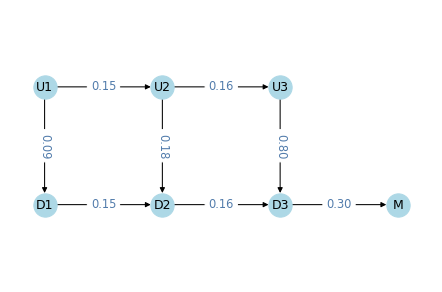

In [11]:
edge_labels = {(u, v): f"{d['p']:.2f}" 
               for u, v, d in G.edges(data=True)}
pos = {}

for i, state in enumerate(['U1', 'U2', 'U3']):
    pos[state] = (i, 1)

for i, state in enumerate(['D1', 'D2', 'D3']):
    pos[state] = (i, 0)

pos['M'] = (3, 0)

nx.draw_networkx(G, pos=pos, node_color='lightblue', node_size=500)
                             
nx.draw_networkx_edge_labels(G, pos, 
                             edge_labels=edge_labels,
                             font_size=11,
                             font_color='C0')
plt.axis('equal')
plt.tight_layout()

In this model, death is only possible after a cancer has progressed to the third stage and been detected.
That's obviously not realistic -- in reality deaths can occur at any stage, due to cancer or other causes.

But adding more transitions would not make make the model better.
The goal is to show that we can reproduce survival rates even with restrictive assumptions, so we'll minimize the number of parameters.

It might also help to think of the states more abstractly.
For example, a transition from `D2` to `D3` might literally represent a cancer that progresses from one stage to another, but it could also include someone whose risk of mortality has increased to be comparable to someone at the next stage, due to other causes.

## Simulation

To simulate the model, we'll use the Markov chain implementation in the [QuantEcon package](https://quanteconpy.readthedocs.io/en/latest/)).

The following function extracts the probabilities in the graph and makes a transition matrix we can use with QuantEcon.

In [12]:
def make_transition_matrix(G, states):
    n_states = len(states)

    # Create a mapping from state names to indices
    state_to_idx = {state: i for i, state in enumerate(states)}

    # Initialize the transition matrix with zeros
    P = np.zeros((n_states, n_states))

    # Fill in the transition probabilities from the graph
    for i, state in enumerate(states):

        total_prob = 0
        for neighbor in G.successors(state):
            j = state_to_idx[neighbor]
            prob = G[state][neighbor]['p']
            P[i, j] = prob
            total_prob += prob

        # Add self-loop probability (staying in the same state)
        P[i, i] = 1 - total_prob

    # For absorbing state 'M', set self-transition to 1
    M_idx = state_to_idx['M']
    P[M_idx, M_idx] = 1
    return P

In [13]:
states = ['U1', 'U2', 'U3', 'D1', 'D2', 'D3', 'M']
P = make_transition_matrix(G, states)
pd.DataFrame(P, index=states, columns=states)

,U1,U2,U3,D1,D2,D3,M
U1,0.76,0.15,0.00,0.09,0.00,0.00,0.0
U2,0.00,0.66,0.16,0.00,0.18,0.00,0.0
U3,0.00,0.00,0.20,0.00,0.00,0.80,0.0
D1,0.00,0.00,0.00,0.85,0.15,0.00,0.0
D2,0.00,0.00,0.00,0.00,0.84,0.16,0.0
D3,0.00,0.00,0.00,0.00,0.00,0.70,0.3
M,0.00,0.00,0.00,0.00,0.00,0.00,1.0


Now we can make a `MarkovChain` object.

In [14]:
from quantecon import MarkovChain

mc = MarkovChain(P, state_values=states)

We'll run 100 simulated years so we have survival times for all cases (with high probability).

In [15]:
state_seq = mc.simulate(ts_length=100, init='U1')
state_seq

array(['U1', 'U1', 'U1', 'U1', 'U1', 'U1', 'U1', 'U1', 'U2', 'D2', 'D2',
       'D2', 'D2', 'D2', 'D3', 'D3', 'D3', 'D3', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M'],
      dtype='<U2')

To analyze the results, we'll use the following function, which takes a state sequence and returns the time of diagnosis and stage at diagnosis.

In [16]:
def diagnosed(state_seq):
    for i, state in enumerate(state_seq):
        if state.startswith('D'):
            return i, state
    return None, None

In [17]:
diagnosis_index, stage = diagnosed(state_seq)
diagnosis_index, stage

(9, 'D2')

And we'll use the following function to check 5-year survival after diagnosis.
In the rare case where we reach the end of the sequence, that case is counted as a survival.

In [18]:
def survived(state_seq, diagnosis_index, duration=5):
    idx = diagnosis_index + duration
    if idx < len(state_seq):
        return state_seq[idx] != 'M'
    else:
        return True

In [19]:
survived(state_seq, diagnosis_index)

True

Now we'll run many simulations and collect the results.
If a case is never diagnosed, it is omitted -- but that never happens in this example.

In [20]:
n_simulations = 10000
results = []

for _ in range(n_simulations):
    state_seq = mc.simulate(ts_length=100, init='U1')
    diagnosis_index, stage = diagnosed(state_seq)
    if diagnosis_index is not None:
        flag = survived(state_seq, diagnosis_index)
        results.append((diagnosis_index, stage, flag))
        
len(results)

10000

Here are the first few rows.

In [21]:
df = pd.DataFrame(results, columns=['age', 'stage', 'survived'])
df.head()

,age,stage,survived
0,5,D1,True
1,13,D2,True
2,2,D2,False
3,6,D1,True
4,11,D1,True


For the hypothetical cancer, the overall 5-year survival rate is about 64%, the same as colon cancer in reality.

In [22]:
df['survived'].mean()

0.6425

Here are the survival rates by stage.

In [23]:
rates = df.groupby('stage')['survived'].mean() * 100
pd.DataFrame(dict(rates=rates))

,rates
stage,
D1,94.700399
D2,71.687292
D3,16.848568


The actual survival rates for colon cancer are 91% if localized, 74% if regional, and 16% if distant.
So the simulation results are not exactly the same, but they are close.

And here is the distribution of stage at diagnosis.

In [24]:
from empiricaldist import Pmf

Pmf.from_seq(df['stage'], name='incidence') * 100

,probs
stage,
D1,37.55
D2,33.13
D3,29.32


The actual distribution for colon cancer is 38% localized, 38% regional, and 24% distant.
Again, the simulation results are not exactly the same, but close.

With more trial and error, I could probably find parameters that reproduce the results exactly.
That would not be surprising, because even though the model is meant to be parsimonious, it has seven parameters (not counting `gamma`, which we fixed at 0) and we are matching observations with only five degrees of freedom.

That might seem unfair, but it makes the point that there are not enough numbers in the survival table -- even if we also consider the distribution of stages -- to conclude that early detection would have any benefit.

The model we constructed has almost the same survival rates as colon cancer, but detection has no effect on survival time.
Therefore, **survival rates do not make the case that it is better to find cancer early**.

Again, it *might* be better to find cancer early, if the benefit of treatment outweighs the costs of false discovery and overdiagnosis -- but that's a more complicated analysis, and 5-year survival rates aren't part of it.

## Counterfactuals

[Later in the video](https://youtu.be/ph2ZeNooFLg?t=836), Taleb says, "Your mother, had she had a colonoscopy, she would be alive today... she's no longer with us because it was detected when it was stage IV, right?" And Gal agrees.

That *might* be true, if treatment would have prevented the cancer from progressing.
But this conclusion is not supported by the data in the survival table.

If someone is diagnosed with stage IV colon cancer and dies, it is tempting to look at the survival table and think there's a 91% chance they would have survived if they had been diagnosed earlier.

But that's not true -- it's probably not even close to true. 

* First, that 91% includes cancers that would have progressed slowly or never, even without treatment. In the case of someone who died, we know their cancer was not one of those.

* Also, surviving five years after stage I is more likely than surviving five years after stage IV, even without treatment.

The five-year survival rate answers the question, "Of all people diagnosed at stage I, how many survive five years?" That is a straightforward statistic to compute.

But the hypothetical asks a different question: "Of all people who died [during a particular interval] after being diagnosed at stage IV, how many would be alive [at some later point] if the tumor had been detected by a screening test when it was stage I?" That is a *much* harder question to answer -- and the five-year survival rate provides little or no help.

In general, we don't know whether someone would not have died if they had been diagnosed earlier.
The actual probability depends on progression rates with and without treatment.
In the limiting cases:

* If treatment is ineffective, as in the hypothetical cancer we simulated, the probability is zero.

* If treatment is perfectly effective, the probability is 100%.

In reality, it could be anywhere in between.

## Markov analysis with PyMC

Instead of QuantEcon, we could have used PyMC to simulate the Markov chain.

In [25]:
# pip install pymc pymc-extras

import pymc as pm
import pymc_extras as pmx

# map labels <-> ints
state_to_idx = {s: i for i, s in enumerate(states)}
idx_to_state = np.array(states)

# initial distribution: start in 'U1'
init_probs = np.zeros(len(states))
init_probs[state_to_idx['U1']] = 1.0

In [26]:
T = 100    # number of time steps     
N = 10     # number of trajectories

with pm.Model():
    init_dist = pm.Categorical.dist(p=init_probs)
    chain_rv = pmx.DiscreteMarkovChain("chain", P=P, init_dist=init_dist, shape=(T,))

# Fast, no idata:
traj = pm.draw(chain_rv, draws=N)

In [27]:
traj_labels = idx_to_state[traj]
traj_labels[0]

array(['U1', 'U2', 'U2', 'U3', 'U3', 'D3', 'D3', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M'], dtype='<U2')

Copyright 2025 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)